In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load""

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-recsys/sample_submission.csv
/kaggle/input/test-recsys/tab_6_city.csv
/kaggle/input/test-recsys/sbermarket_tab_2_4/tab_2_products_2020-06-19.csv
/kaggle/input/test-recsys/sbermarket_tab_2_4/tab_2_products_2020-06-29.csv
/kaggle/input/test-recsys/sbermarket_tab_2_4/tab_2_products_2020-06-09.csv
/kaggle/input/test-recsys/sbermarket_tab_2_3/tab_2_products_2020-05-10.csv
/kaggle/input/test-recsys/sbermarket_tab_2_3/tab_2_products_2020-05-20.csv
/kaggle/input/test-recsys/sbermarket_tab_2_3/tab_2_products_2020-05-30.csv
/kaggle/input/test-recsys/sbermarket_tab_2_6/tab_2_products_2020-08-18.csv
/kaggle/input/test-recsys/sbermarket_tab_2_6/tab_2_products_2020-09-07.csv
/kaggle/input/test-recsys/sbermarket_tab_2_6/tab_2_products_2020-08-08.csv
/kaggle/input/test-recsys/sbermarket_tab_2_6/tab_2_products_2020-08-28.csv
/kaggle/input/test-recsys/kaggle_tab_1345/tab_3_categories.csv
/kaggle/input/test-recsys/kaggle_tab_1345/tab_1_orders.csv
/kaggle/input/test-recsys/kaggle_tab_13

In [2]:
# !pip install git+https://github.com/maciejkula/spotlight

In [3]:
df_orders = pd.read_csv('../input/test-recsys/kaggle_tab_1345/tab_1_orders.csv')
df_categories = pd.read_csv('../input/test-recsys/kaggle_tab_1345/tab_3_categories.csv')
df_user_profiles = pd.read_csv('../input/test-recsys/kaggle_tab_1345/tab_4_user_profiles.csv')
df_product_prop = pd.read_csv('../input/test-recsys/kaggle_tab_1345/tab_5_product_properties.csv')
df_city = pd.read_csv('../input/test-recsys/tab_6_city.csv')

In [4]:
df_orders = df_orders.merge(df_user_profiles, on='user_id')
df_orders = df_orders.merge(df_city, on='store_id')

df_orders['order_created_time'] = pd.to_datetime(df_orders['order_created_time'])
df_orders['order_created_date'] = df_orders['order_created_time'].dt.date
df_orders['order_created_month'] = df_orders['order_created_time'].dt.month
df_orders['order_created_weekday'] = df_orders['order_created_time'].dt.weekday
df_orders['order_created_hour'] = df_orders['order_created_time'].dt.hour

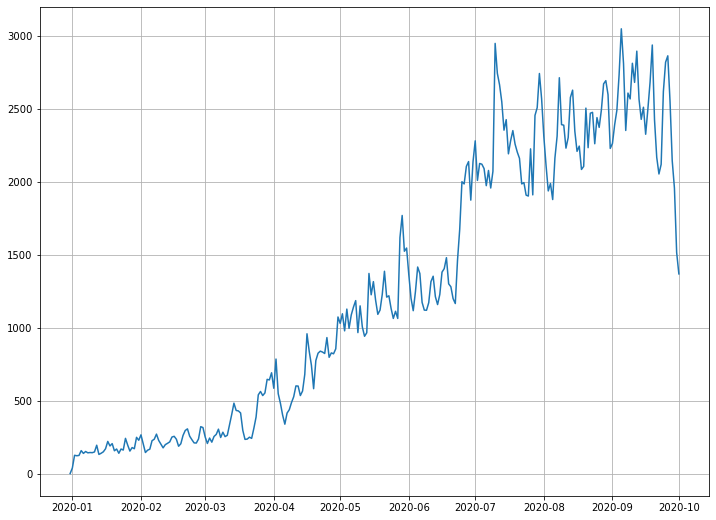

In [5]:
plt.figure(figsize=(12, 9))
df_orders['order_created_date'].value_counts().plot()
plt.grid()

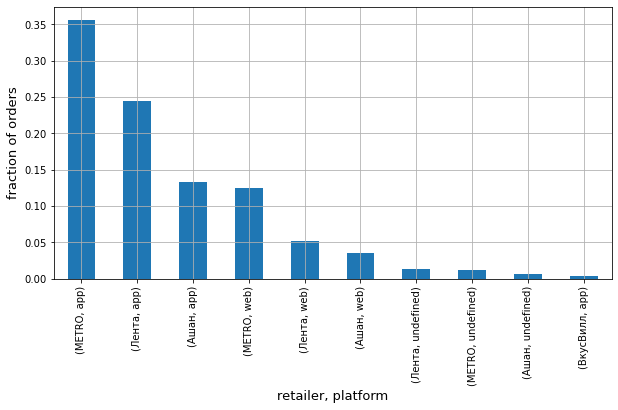

In [6]:
plt.figure(figsize=(10, 5))
(df_orders[['retailer', 'platform']].value_counts()[:10] / (df_orders[['retailer', 'platform']].value_counts().sum())).plot(kind='bar')
plt.xlabel('retailer, platform', fontsize=13)
plt.ylabel('fraction of orders', fontsize=13)
plt.grid()

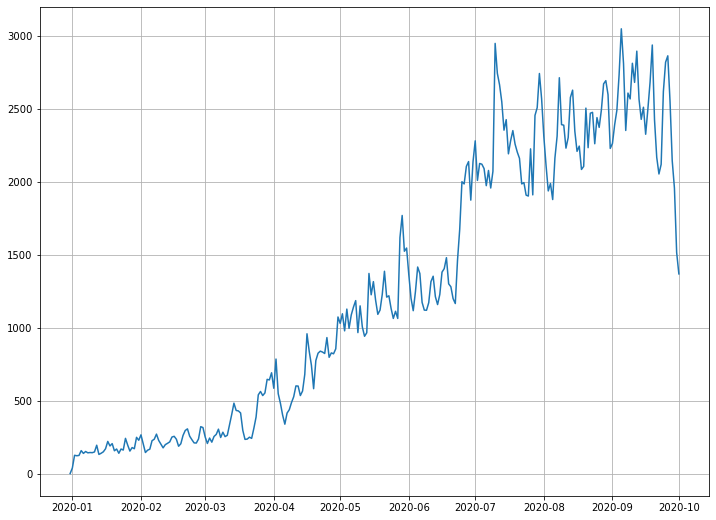

In [7]:
plt.figure(figsize=(12, 9))
df_orders['order_created_date'].value_counts().plot()
plt.grid()

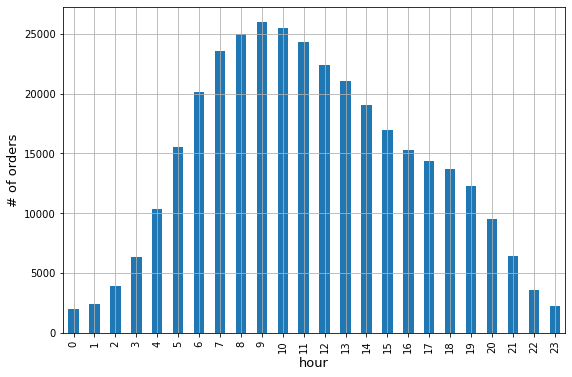

In [8]:
plt.figure(figsize=(9, 6))
df_orders['order_created_hour'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('hour', fontsize=13)
plt.ylabel('# of orders', fontsize=13)
plt.grid()

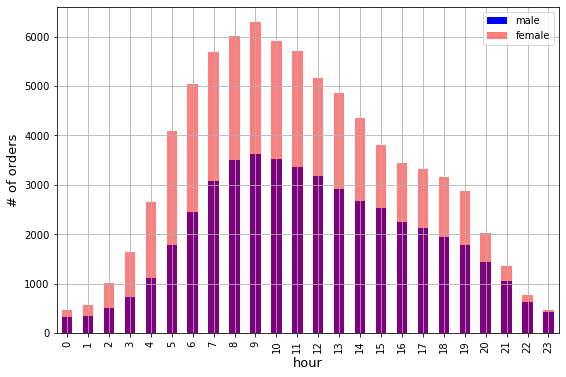

In [9]:
plt.figure(figsize=(9, 6))
df_orders['order_created_hour'][df_orders['gender'] == 'male'].value_counts().sort_index().plot(kind='bar', color='b', label='male')
df_orders['order_created_hour'][df_orders['gender'] == 'female'].value_counts().sort_index().plot(kind='bar', color='r', alpha=0.5, label='female')
plt.xlabel('hour', fontsize=13)
plt.ylabel('# of orders', fontsize=13)
plt.legend()
plt.grid()
plt.show()

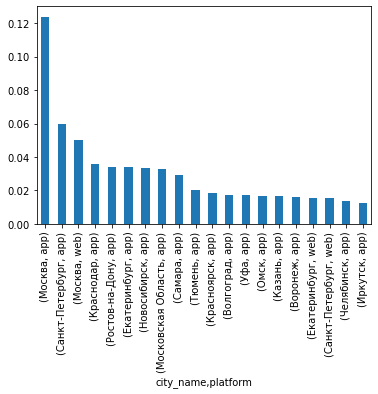

In [10]:
df_orders[['city_name', 'platform']].value_counts(normalize=True)[:20].plot(kind='bar')

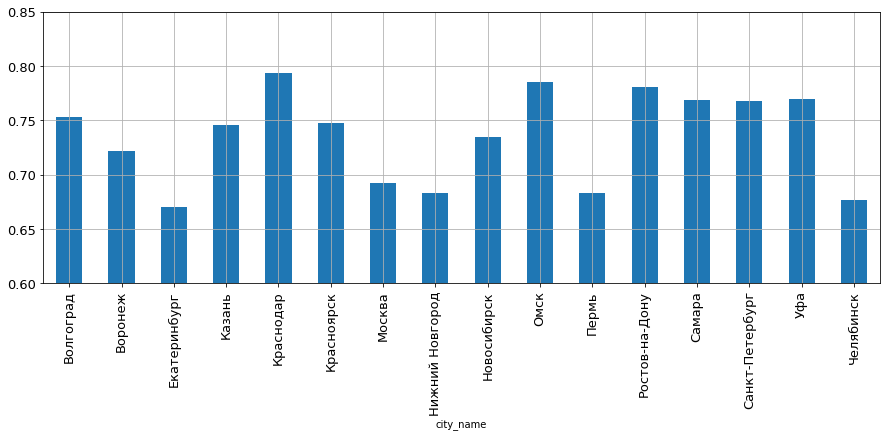

In [11]:
df_orders['is_app'] = (df_orders[['platform']] == 'app').astype(int)
city_orders = df_orders[['is_app']].groupby(df_orders['city_name']).mean()#.value_counts(normalize=True)[:20].plot(kind='bar
city_orders['count'] = df_orders['is_app'].groupby(df_orders['city_name']).count()
top_city_ord = city_orders[city_orders.index.isin(['Москва', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург',
                                   'Нижний Новгород', 'Казань', 'Челябинск', 'Омск', 'Самара',
                                   'Ростов-на-Дону', 'Уфа', 'Красноярск', 'Воронеж', 'Пермь', 'Волгоград',
                                   'Краснодар'])]
top_city_ord['is_app'].plot(kind='bar', figsize=(15, 5), ylim=(0.6,0.85), grid=True, fontsize=13)

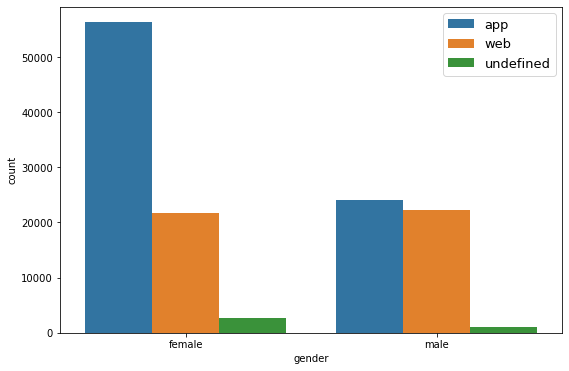

In [12]:
plt.figure(figsize=(9,6))
sns.countplot(x=df_orders['gender'], hue=df_orders['platform'])
plt.legend(fontsize=13)

In [13]:
import glob

ok_columns = ['user_id', 'order_id','price', 'quantity', 'discount','product_id']

tables = {
    'orders': '/kaggle/input/test-recsys/kaggle_tab_1345/tab_1_orders.csv',
    'products': list(sorted(glob.glob('/kaggle/input/test-recsys/sbermarket_tab_2*/*'))),
    'categories': '/kaggle/input/test-recsys/kaggle_tab_1345/tab_3_categories.csv',
    'users': '/kaggle/input/test-recsys/kaggle_tab_1345/tab_4_user_profiles.csv',
    'product_properties': '/kaggle/input/test-recsys/kaggle_tab_1345/tab_5_product_properties.csv',
    'cities': '/kaggle/input/test-recsys/tab_6_city.csv',
    'sample_submission': '/kaggle/input/test-recsys/sample_submission.csv',
}

products = pd.concat(list(map(lambda x: pd.read_csv(x)[ok_columns].assign(date = x[-14:-4]), tables['products'])))

products.date = pd.to_datetime(products.date)
products['total_cash'] = products['price'] * products['quantity']

In [14]:
products_grouped = products.groupby(products['order_id'], as_index=False)[['discount', 'total_cash']].sum()

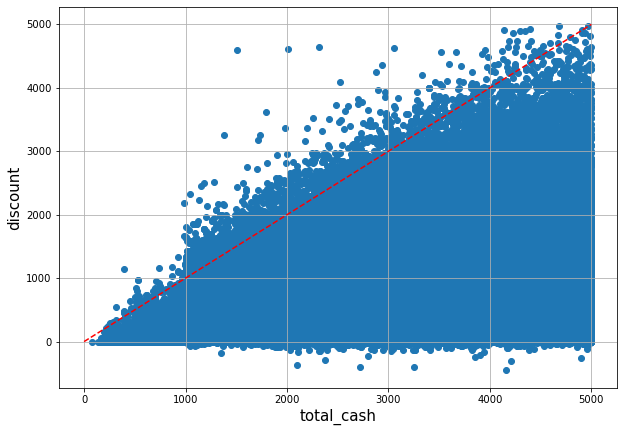

<Figure size 432x288 with 0 Axes>

In [15]:
plt.figure(figsize=(10, 7))
plt.scatter(products_grouped['total_cash'][products_grouped.discount < 5e3][products_grouped.total_cash < 5e3],
            products_grouped['discount'][products_grouped.discount < 5e3][products_grouped.total_cash < 5e3])
plt.plot(np.linspace(0, 5e3, 10), np.linspace(0, 5e3, 10), linestyle='dashed', color='r')
plt.xlabel('total_cash', fontsize=15)
plt.ylabel('discount', fontsize=15)
plt.grid()
plt.figure()
plt.show()  # ['total_cash'][products_grouped['total_cash'] < 1e5] [products_grouped.discount > products_grouped.total_cash]

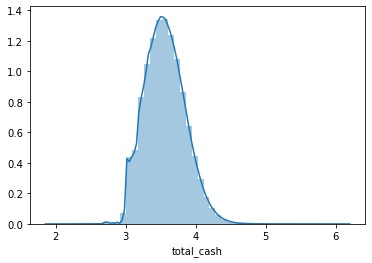

In [16]:
sns.distplot(np.log10(products_grouped['total_cash']))

In [17]:
products_grouped = products['order_id'].groupby(products['product_id']).value_counts()

In [18]:
product_freqs = products.groupby(['product_id'])['order_id'].count() 
product_freqs = product_freqs / products['order_id'].nunique()

In [19]:
product_freqs = product_freqs.sort_values(ascending=False)

In [20]:
# product_freqs.to_csv('fraction_of_transaction_with_product.csv')

In [21]:
def outliers(data):
    
    q_low = data.quantile(0.01)
    q_hi  = data.quantile(0.99)

    boundary = [q_low, q_hi]
    
    return boundary 

In [22]:
product_freqs = products.groupby(['product_id'])['order_id'].count().reset_index()
product_freqs.columns = ['product_id', 'cnt']
product_freqs = product_freqs.sort_values('cnt', ascending=False)
print(product_freqs.cnt.sum())
product_freqs

59596980


,product_id,cnt
0,0,612677
195,709,368956
9330,39590,112981
72,166,98763
10662,55133,96574
...,...,...
90051,7996840,1
53824,5576232,1
90050,7996821,1
53820,5576197,1
